In [7]:
# imports all the necessary files
# following tutorial from https://www.tensorflow.org/tutorials/images/classification

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

# print version of tensorflow
# print(tf.__version__)
# the version that I have is 2.4.1

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [8]:
# imports the flower images dataset from the google API
# flower_photo/
#  daisy/
#  dandelion/
#  roses/
#  sunflowers/
#  tulips/


import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3670


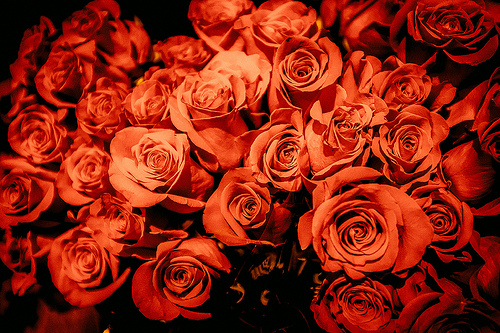

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[2]))

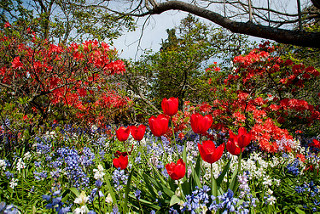

In [9]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[4]))

In [10]:
# define some parameters of the image
# batch size is size of batches of data (default is 32)
# other parameters are listed here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

batch_size = 32
img_height = 180
img_width = 180


In [11]:
# validation split normally 80% of images for training and 20% for validation meaning validation_split set to 0.2
# this is the set used to train the model

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
# this is the set used to validated the model

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
# these attributes are listed in the datasets (directory names in alphabetical order)
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


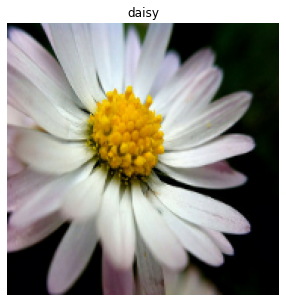

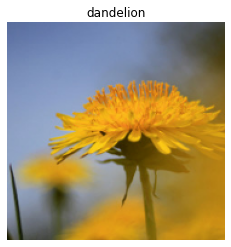

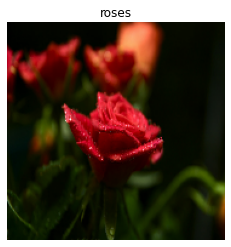

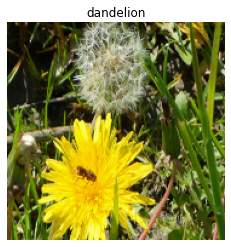

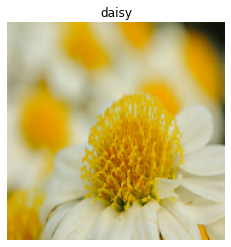

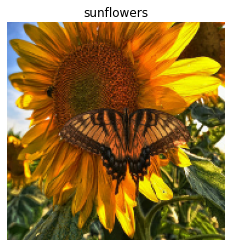

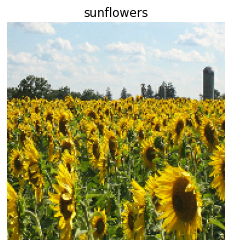

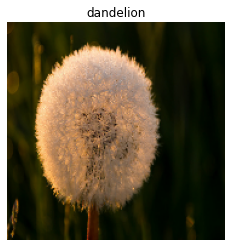

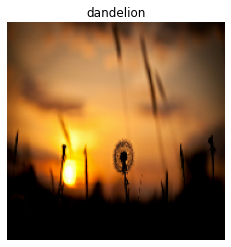

In [16]:
# obtain the 1st 9 images from the training dataset
# was running into an issue where not all the images were showing, 
# used: https://stackoverflow.com/questions/39947551/how-to-display-ndarray-images-inline-during-loop-in-ipython/39953765
# to solve that by putting a plt.show() statement at the end of each instance in the for loop

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(9):
        # show the image
        plt.imshow(images[i].numpy().astype("uint8"))
        # gets name of the flower (from directory and sets as label for image)
        plt.title(class_names[labels[i]])
        # removes axis
        plt.axis("off")
        plt.show()

In [14]:
# to see the batches of images we can print the tensor shape of each batch (we can also convert the tensors to arrays)
# image_batch is tensor of shape (32, 180, 180, 3) - 32 images of shape 180x180x3 where 3 is the color channels (RGB)
# label_batch is tensor of shape (32, ), these are corresponding labels to the 32 images

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 180, 180, 3)
(32,)


In [15]:
# different methods for running data
# dataset.cache() - keeps images in memory after they're loaded off disk during the first epoch. 
# ensure dataset does not become a bottleneck while training your model. If dataset is too large
# to fit into memory can also use this method to create a performant on-disk cache
# 
# dataset.prefetch() - overlaps data preprocessing and model execution while training

# more info: https://www.tensorflow.org/guide/data_performance#prefetching

# was stuck on this portion for quite a while, it seems the guide shows 
# AUTOTUNE = tf.data.AUTOTUNE, but it's only defined under experimental
# doing that made AUTOTUNE defined.
# referenced: https://www.tensorflow.org/datasets/performances
# also found a tensorflow patchnotes: 
# https://www.exxactcorp.com/blog/News/tensorflow-2-4-0-released
# which should have shifted the tf.data.experimental to just tf.data
# but it didn't seem to be the case for my version
# after reading the patchnotes I checked my version and realized
# I have tensorflow 2.3... (spent the entire day trying to figure out
# a work around T.T)
# so if you have a version higher than 2.3 
# AUTOTUNE = tf.data.AUTOTUNE should work
# ended up just upgrading the version of tensorflow to 2.4.1

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
# standardizes the values to be in [0,1] range instead of [0, 255] (RGB)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
# apply the rescaling layer to the dataset by calling map
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))



0.0 1.0


In [19]:
# then we create the model
# model has 3 convolution blocks with max pool layer in each of them. 
# fully connected layer with 128 units on top of it that is activated by a relu
# activation function, (standard approach of creating model)

num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [20]:
# choose an optimizer and loss function to view training and validation
# accuracy for each training epoch, pass the metrics argument
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [22]:
# this is to train the model

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 35s 375ms/step - loss: 1.5069 - accuracy: 0.3415 - val_loss: 1.0793 - val_accuracy: 0.5749
Epoch 2/10
92/92 [==============================] - 30s 321ms/step - loss: 1.0013 - accuracy: 0.6000 - val_loss: 1.0383 - val_accuracy: 0.6035
Epoch 3/10
92/92 [==============================] - 29s 318ms/step - loss: 0.8353 - accuracy: 0.6809 - val_loss: 0.9182 - val_accuracy: 0.6376
Epoch 4/10
92/92 [==============================] - 29s 319ms/step - loss: 0.5822 - accuracy: 0.7979 - val_loss: 0.9734 - val_accuracy: 0.6362
Epoch 5/10
92/92 [==============================] - 30s 325ms/step - loss: 0.3983 - accuracy: 0.8614 - val_loss: 1.0231 - val_accuracy: 0.6540
Epoch 6/10
92/92 [==============================] - 30s 324ms/step - loss: 0.2450 - accuracy: 0.9230 - val_loss: 1.2063 - val_accuracy: 0.6444
Epoch 7/10
92/92 [==============================] - 30s 325ms/step - loss: 0.1312 - accuracy: 0.9679 - val_loss: 1.3096 - val_accuracy: 0.6703

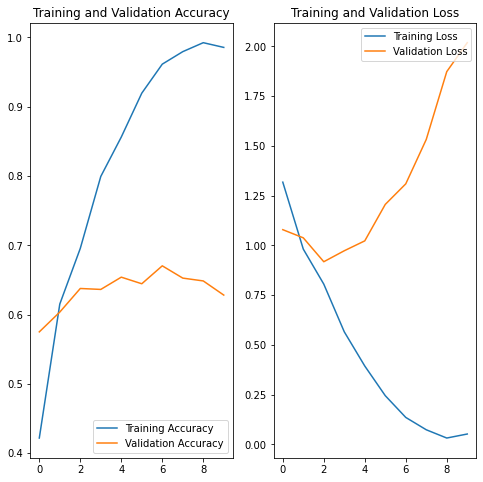

In [23]:
# now we visualize the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
# generate additional training data from existing examples (random transformations)
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

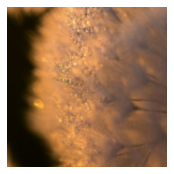

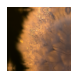

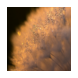

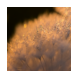

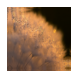

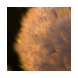

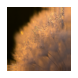

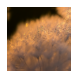

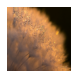

In [26]:
# shows how some of the images look like after transformations
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.show()

In [27]:
# can reduce overfitting by regularization (randomly drops out a number
# of output units from the layer during the training process)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [28]:
# choose an optimizer and loss function to view training and validation
# accuracy for each training epoch, pass the metrics argument
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [30]:
# this is to train the model
# can take some time

epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/15
92/92 [==============================] - 35s 365ms/step - loss: 1.5732 - accuracy: 0.3262 - val_loss: 1.1180 - val_accuracy: 0.5477
Epoch 2/15
92/92 [==============================] - 34s 372ms/step - loss: 1.0788 - accuracy: 0.5665 - val_loss: 1.0550 - val_accuracy: 0.5967
Epoch 3/15
92/92 [==============================] - 34s 366ms/step - loss: 0.9971 - accuracy: 0.6134 - val_loss: 0.9337 - val_accuracy: 0.6362
Epoch 4/15
92/92 [==============================] - 33s 360ms/step - loss: 0.8846 - accuracy: 0.6619 - val_loss: 0.9178 - val_accuracy: 0.6376
Epoch 5/15
92/92 [==============================] - 33s 359ms/step - loss: 0.8708 - accuracy: 0.6746 - val_loss: 0.9320 - val_accuracy: 0.6308
Epoch 6/15
92/92 [==============================] - 33s 358ms/step - loss: 0.8112 - accuracy: 0.6953 - val_loss: 0.8009 - val_accuracy: 0.6689
Epoch 7/15
92/92 [==============================] - 33s 358ms/step - loss: 0.7334 - accuracy: 0.7113 - val_loss: 0.8008 - val_accuracy: 0.6839

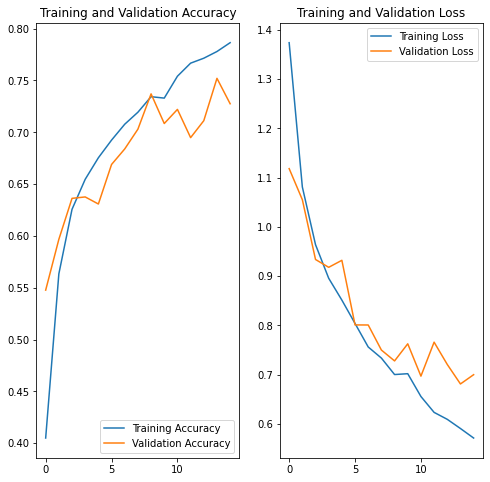

In [31]:
# visualize the new results after dropout
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [2]:
# now we try to predict new data

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# load the image at a specific size
img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)

# convert the image to array
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# predict based on model set up above
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

NameError: name 'tf' is not defined